In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import requests
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_housing_data():
  tar_path = Path("datasets/housing.tgz")

  if not tar_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"

    # download .tgz
    response = requests.get(url)
    assert response.status_code == 200, "failed to download the data file"
    with open(tar_path, "wb") as file:
      file.write(response.content)

    # extract .tgz
    with tarfile.open(tar_path) as file:
      file.extractall(Path("datasets"))

  # read as DataFrame
  return pd.read_csv(Path("datasets/housing/housing.csv"));

In [3]:
housing = load_housing_data()
pd.set_option('display.width', 1000)

print(housing[:5])

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value ocean_proximity
0    -122.23     37.88                41.0        880.0           129.0       322.0       126.0         8.3252            452600.0        NEAR BAY
1    -122.22     37.86                21.0       7099.0          1106.0      2401.0      1138.0         8.3014            358500.0        NEAR BAY
2    -122.24     37.85                52.0       1467.0           190.0       496.0       177.0         7.2574            352100.0        NEAR BAY
3    -122.25     37.85                52.0       1274.0           235.0       558.0       219.0         5.6431            341300.0        NEAR BAY
4    -122.25     37.85                52.0       1627.0           280.0       565.0       259.0         3.8462            342200.0        NEAR BAY


In [4]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [5]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
count  20640.000000  20640.000000        20640.000000  20640.000000    20433.000000  20640.000000  20640.000000   20640.000000        20640.000000
mean    -119.569704     35.631861           28.639486   2635.763081      537.870553   1425.476744    499.539680       3.870671       206855.816909
std        2.003532      2.135952           12.585558   2181.615252      421.385070   1132.462122    382.329753       1.899822       115395.615874
min     -124.350000     32.540000            1.000000      2.000000        1.000000      3.000000      1.000000       0.499900        14999.000000
25%     -121.800000     33.930000           18.000000   1447.750000      296.000000    787.000000    280.000000       2.563400       119600.000000
50%     -118.490000     34.260000           29.000000   2127.000000      435.000000   1166.000000    409.000000       

In [6]:
print(housing["ocean_proximity"].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


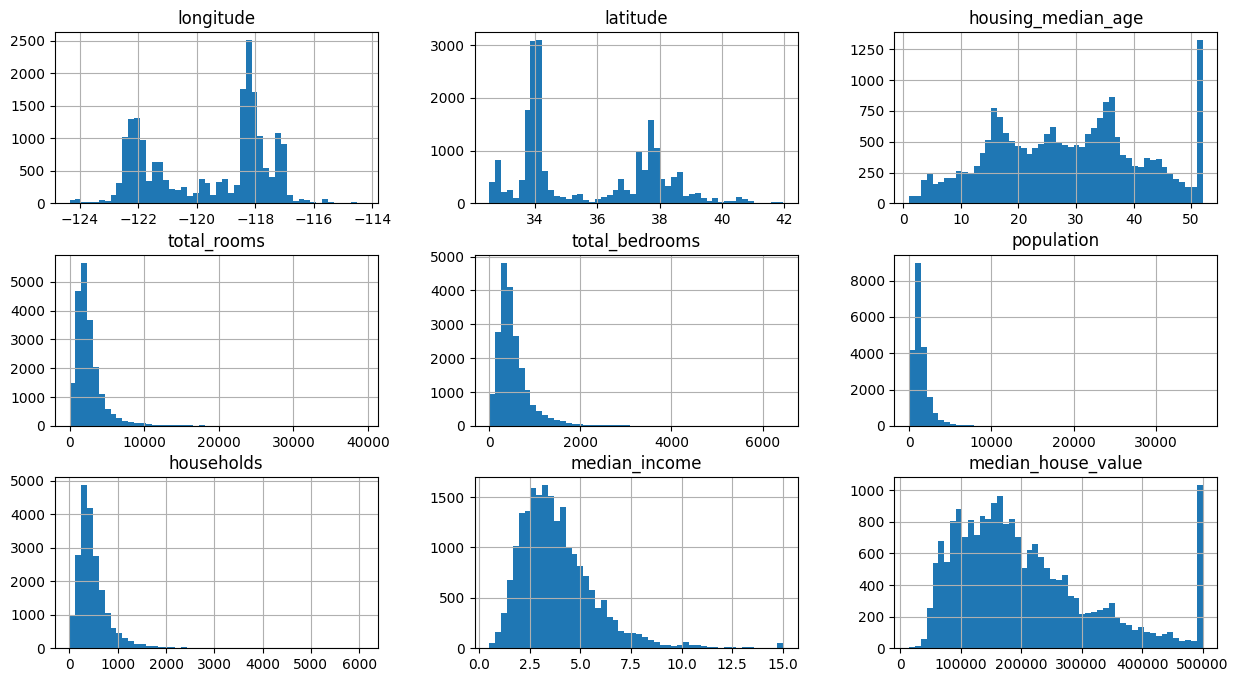

In [23]:
housing.hist(bins=50, figsize=(15, 8))
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=0.1, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init=10)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


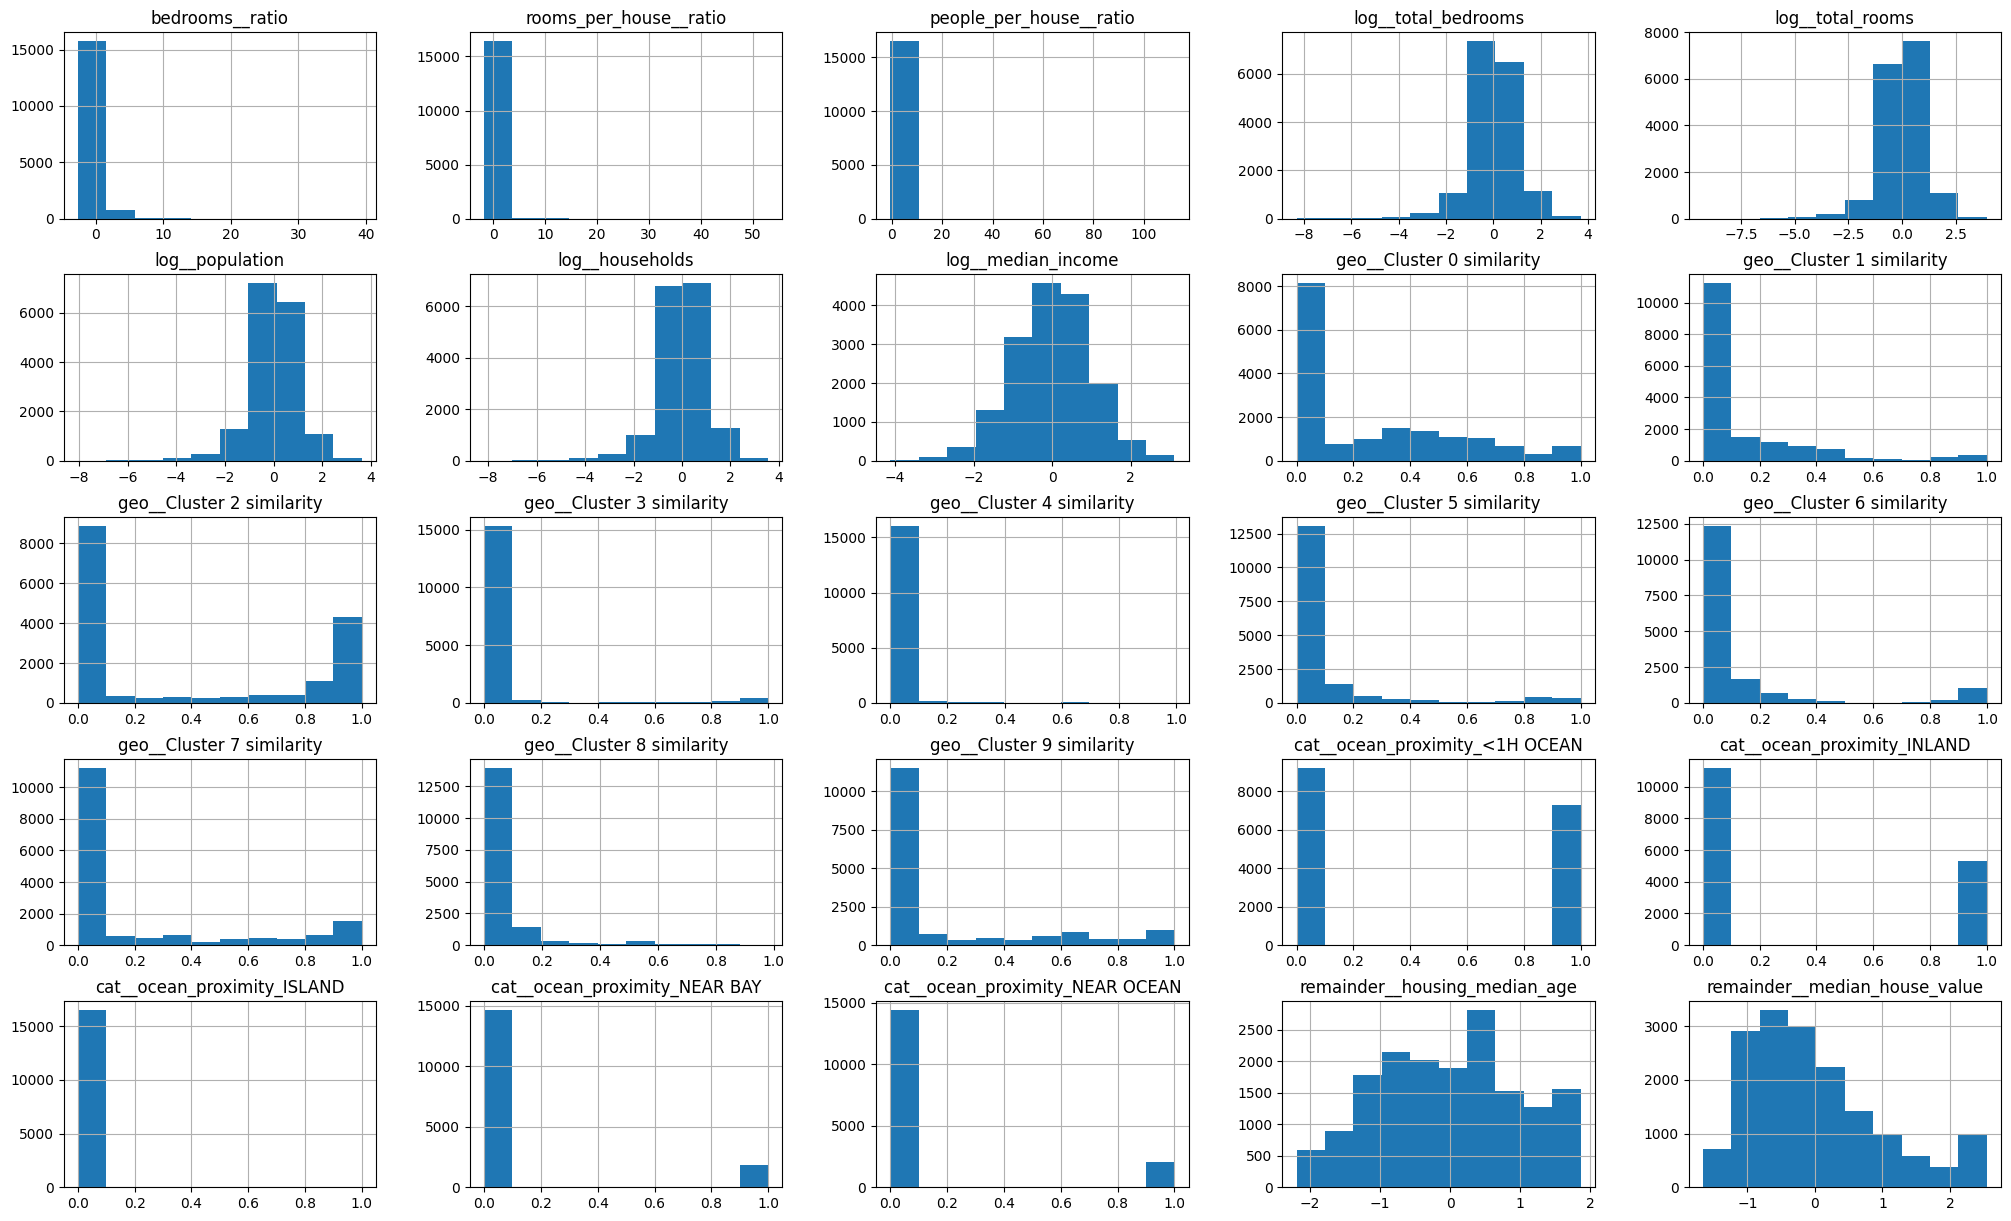

In [36]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# import sklearn.impute as impute
# import sklearn.preprocessing as preprocessing
# import sklearn.compose as compose

def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler()
  )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())


preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_similarity, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object) )
], remainder= default_num_pipeline) # one remainder: housing_median_age

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())
housing_prepared.hist(figsize=(25, 15))
plt.show()